# Image enhancement using an encoder-decoder CNN
The goal of this notebook is to use an encoder-decoder CNN model to colorise grayscale landscape images.

## Preparation


### Kaggle

In [1]:
import os
import getpass

kaggle_ids = getpass.getpass('Content of your ~/.kaggle/kaggle.json: ')
os.environ['KAGGLE_JSON'] = kaggle_ids

!mkdir ~/.kaggle; echo $KAGGLE_JSON > ~/.kaggle/kaggle.json; chmod 600 ~/.kaggle/kaggle.json

Content of your ~/.kaggle/kaggle.json:  ········


### Downloading and compressing images



In [2]:
!pip install -qq --upgrade pip
!pip install -qq kaggle
!mkdir /content/dataset
#!kaggle datasets download -d farhanhaikhan/general-purpose-image-dataset -p /content/dataset --unzip; mv /content/dataset/dataset/* /content/dataset/
!kaggle datasets download -d arnaud58/landscape-pictures -p /content/dataset --unzip

 99%|███████████████████████████████████████▊| 617M/620M [00:22<00:00, 18.2MB/s]
100%|████████████████████████████████████████| 620M/620M [00:22<00:00, 28.8MB/s]


### Image preprocessing
We resize the pictures to a more manageable size, while keeping in mind that the final size must be divisible by 32 (five downsampling operations, 2^5 = 32).

In [1]:
!pip install -qq numpy Pillow
import io
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from itertools import chain
from PIL import Image, ImageEnhance


SHAPE_INPUT = (512, 512, 3)
SHAPE_OUTPUT = (512, 512, 3)
SIZE_INPUT = SHAPE_INPUT[:2]
SIZE_OUTPUT = SHAPE_OUTPUT[:2]


def load_lum(array):
    return Image.fromarray(np.uint8(np.squeeze(array * 255.0, axis=-1)), mode='L').convert('RGB')

def is_gray(im, tolerance=5.0):
    r, g, b = im.split()
    return np.allclose(r, g, atol=tolerance) and np.allclose(r, b, atol=tolerance)

def resize_keep_aspect(img_array, size):
    return keras.preprocessing.image.smart_resize(img_array, (size[1], size[0]), interpolation='bilinear')

def process_images_for_training(src_directory, dest_directory):
    folder = pathlib.Path(src_directory).resolve()
    extensions = {'*.jpg', '*/*.jpg', '*.jpeg', '*/*.jpeg'}
    images = set(chain.from_iterable(folder.glob(ext) for ext in extensions))

    nb_img, nb_errors, nb_wrongsize, nb_gray = len(images), 0, 0, 0
    print(f'Found {nb_img} images.')

    for i, image_file in enumerate(images):
        try:
            im = Image.open(image_file)
        except OSError:
            nb_errors += 1
            continue

        if im.width < SHAPE_OUTPUT[0] or im.height < SHAPE_OUTPUT[1]:
            nb_wrongsize += 1
            continue

        if im.mode != 'RGB':
            im = im.convert('RGB')
        
        if is_gray(im):
            nb_gray += 1
            continue

        im = ImageEnhance.Color(im).enhance(1.25)

        hsv = np.array(im.convert('HSV'))
        truth_img = resize_keep_aspect(hsv, SIZE_OUTPUT) / 255.0
        assert np.shape(truth_img) == SHAPE_OUTPUT
        
        gray = np.array(im.convert('L').convert('HSV'))
        input_img = resize_keep_aspect(gray, SIZE_INPUT) / 255.0
        #input_img = np.expand_dims(np.array(gray), axis=-1).astype('float32') / 255.0
        assert np.shape(input_img) == SHAPE_INPUT
        
        np.savez(f'{dest_directory}/{i}.npz', input=input_img, truth=truth_img)

        if i % 500 == 0:
            progress = i / nb_img * 100
            print(f'{progress:.2f}% ({i}/{nb_img} WS={nb_wrongsize} E={nb_errors} G={nb_gray})')

    print('\nDone.')

### Processing

In [4]:
!rm -rf /content/training; mkdir /content/training
process_images_for_training('/content/dataset', '/content/training')

Found 4319 images.


2023-12-06 18:33:54.383757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 18:33:54.902560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:a1:00.0, compute capability: 8.0


0.00% (0/4319 WS=0 E=0 G=0)
11.58% (500/4319 WS=57 E=0 G=15)
23.15% (1000/4319 WS=103 E=0 G=30)
34.73% (1500/4319 WS=160 E=0 G=40)
46.31% (2000/4319 WS=197 E=0 G=52)
57.88% (2500/4319 WS=261 E=0 G=63)
69.46% (3000/4319 WS=310 E=0 G=70)
81.04% (3500/4319 WS=356 E=0 G=84)
92.61% (4000/4319 WS=408 E=0 G=96)

Done.


## Building our data pipeline
Instead of loading all the dataset in memory, we'll use a generator that yields pairs of images, the grayscale one to make the prediction on and the ground truth.

### Creating the dataset

In [2]:
import pathlib

BATCH_SIZE = 16
NB_FILES = len(set(pathlib.Path('/content/training').glob('*.npz')))
SPE = NB_FILES // BATCH_SIZE
MOD = NB_FILES % BATCH_SIZE
print(f"{BATCH_SIZE} x {SPE} (+{MOD}) = {NB_FILES}")

16 x 235 (+7) = 3767


In [3]:
!pip install -qq tensorflow-addons
import random
import pathlib
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.data import AUTOTUNE as AUTO


def random_augmentation(image_1, image_2):
    rand_1, rand_2, rand_3 = (float(tf.random.uniform(())) for _ in range(3))

    angle = rand_1 * 0.785
    image_1 = tfa.image.rotate(image_1, angle, fill_mode='reflect', interpolation='bilinear')
    image_2 = tfa.image.rotate(image_2, angle, fill_mode='reflect', interpolation='bilinear')

    if rand_2 < 0.5:
        image_1 = tf.image.flip_left_right(image_1)
        image_2 = tf.image.flip_left_right(image_2)

    if rand_3 < 0.5:
        image_1 = tf.image.flip_up_down(image_1)
        image_2 = tf.image.flip_up_down(image_2)

    return image_1, image_2

def images_generator(path):
    files = sorted(pathlib.Path(path.decode()).glob("*.npz"))

    for f in files:
        pair = np.load(f)
        yield pair['input'], pair['truth']

def get_dataset(source_str):
    output = tf.TensorSpec(shape=SHAPE_INPUT), tf.TensorSpec(shape=SHAPE_OUTPUT)
    spec = tf.data.Dataset.from_generator(images_generator, args=(source_str,), output_signature=output)
    return spec.cache().repeat().shuffle(NB_FILES, reshuffle_each_iteration=True).map(random_augmentation, num_parallel_calls=AUTO).batch(BATCH_SIZE, num_parallel_calls=AUTO).prefetch(AUTO)
    #return spec.cache().repeat().map(random_augmentation, num_parallel_calls=-1).batch(BATCH_SIZE, num_parallel_calls=-1).prefetch(-1)


dataset_training = get_dataset('/content/training/')

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're usin

### Display dataset

2023-12-06 18:37:30.773627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1208 of 3767
2023-12-06 18:37:40.774926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2417 of 3767
2023-12-06 18:37:50.775107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3613 of 3767
2023-12-06 18:37:52.012389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


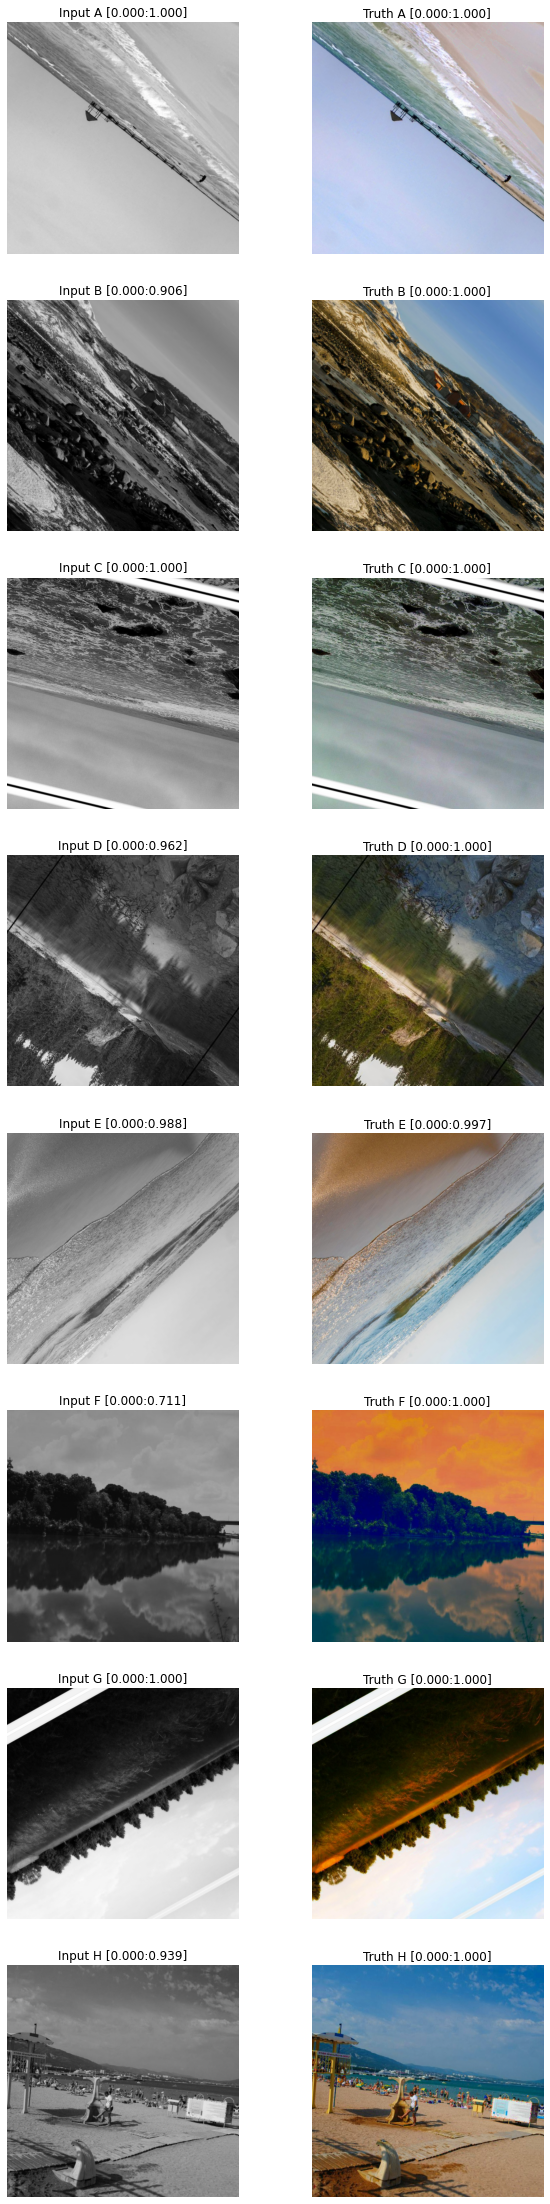

In [7]:
!pip install -qq matplotlib
import string
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import array_to_img


def load_hsv(array):
    return Image.fromarray(np.uint8(array * 255.0), mode='HSV').convert('RGB')

def load_lum(array):
    return Image.fromarray(np.uint8(np.squeeze(array * 255.0, axis=-1)), mode='L').convert('RGB')

batch = list(dataset_training.take(1).as_numpy_iterator())
batchX, batchY = batch[0][0], batch[0][1]
choices = zip(range(8), string.ascii_uppercase)

plt.figure(figsize=(2 * 5, 8 * 5))

for i, l in choices:
    x = batchX[i]
    pixmin, pixmax = np.min(x), np.max(x)
    img = load_hsv(x)
    plt.subplot(8, 2, i*2 + 1)
    plt.imshow(img)
    plt.title(f'Input {l} [{pixmin:.3f}:{pixmax:.3f}]')
    plt.axis('off')

    y = batchY[i]
    pixmin, pixmax = np.min(y), np.max(y)
    img = load_hsv(y)
    plt.subplot(8, 2, i*2 + 2)
    plt.imshow(img)
    plt.title(f'Truth {l} [{pixmin:.3f}:{pixmax:.3f}]')
    plt.axis('off')

## Building the model
The design of the model is a standard encoder-decoder.

We'll use SSIM as our loss function to try and maximise image similarity between prediction and truth. We'll also monitor PSNR as an additional indicator.

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, initializers
from keras.models import Sequential, Model
from keras.constraints import max_norm


def get_model():
    xargs = dict(activation='relu', padding='same', kernel_initializer='he_uniform', use_bias=True, bias_initializer=initializers.Constant(0.05))

    # Input
    inputs = layers.Input(shape=SHAPE_INPUT)
    skips, x = [], inputs
    filter_sizes = [32, 64, 128, 256, 512, 1024]
    
    for f in filter_sizes:
        skip = layers.Conv2D(f, 3, strides=2, **xargs)(x)
        x = layers.Conv2D(f, 3, **xargs)(skip)
        skips.append(skip)
    
    x = layers.Conv2D(2048, 3, padding='same')(x)
    
    for f in reversed(filter_sizes):
        skip = skips.pop()
        x = layers.Conv2DTranspose(f, 3, **xargs)(x)
        x = layers.Add()([x, skip])
        x = layers.Conv2DTranspose(f, 3, strides=2, **xargs)(x)
        
    x = layers.Conv2D(3, 3, padding='same')(x)
    outputs = layers.ReLU(max_value=1.0)(x)

    return Model(inputs=inputs, outputs=outputs)

def minmax(xmin, x, xmax):
    return tf.math.minimum(tf.math.maximum(xmin, x), xmax)

def PSNR(y_true, y_pred):
    psnr = tf.image.psnr(y_true, y_pred, max_val=1.0)
    return minmax(8.0, psnr, 16.0)

def SSIM(y_true, y_pred):
    ssim = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return minmax(0.0, ssim, 1.0)

def SSIM_L(y_true, y_pred):
    return 1.0 - SSIM(y_true, y_pred)

def custom_loss(y_true, y_pred):
    alpha = 0.65
    ssim_loss = SSIM_L(y_true, y_pred)
    mae_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    loss = (alpha * mae_loss + (1-alpha) * ssim_loss)
    return loss

model = get_model()
model.compile(loss=custom_loss,
              metrics=['mean_absolute_error', SSIM, SSIM_L, PSNR],
              optimizer=keras.optimizers.Adamax(learning_rate=0.001))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

## Training

In [19]:
!rm -rf /tmp/tensorboard; rm -f /tmp/training_*
import tempfile
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping

_, checkpoint_train = tempfile.mkstemp(prefix='training_', suffix='.h5', dir='/tmp')
checkpoint_t = ModelCheckpoint(checkpoint_train, monitor='loss', save_best_only=True)
early_stop = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)

training = model.fit(dataset_training, epochs=100, steps_per_epoch=SPE, callbacks=[checkpoint_t, early_stop], initial_epoch=60)

Epoch 61/100
235/235 [==============================] - 52s 210ms/step - loss: 0.1791 - mean_absolute_error: 0.1348 - SSIM: 0.7386 - SSIM_L: 0.2614 - PSNR: 14.2371
Epoch 62/100
235/235 [==============================] - 38s 160ms/step - loss: 0.1779 - mean_absolute_error: 0.1339 - SSIM: 0.7402 - SSIM_L: 0.2598 - PSNR: 14.2899
Epoch 63/100
235/235 [==============================] - 37s 158ms/step - loss: 0.1796 - mean_absolute_error: 0.1353 - SSIM: 0.7380 - SSIM_L: 0.2620 - PSNR: 14.2127
Epoch 64/100
235/235 [==============================] - 38s 161ms/step - loss: 0.1775 - mean_absolute_error: 0.1332 - SSIM: 0.7401 - SSIM_L: 0.2599 - PSNR: 14.2855
Epoch 65/100
235/235 [==============================] - 37s 159ms/step - loss: 0.1766 - mean_absolute_error: 0.1330 - SSIM: 0.7424 - SSIM_L: 0.2576 - PSNR: 14.2865
Epoch 66/100
235/235 [==============================] - 36s 155ms/step - loss: 0.1784 - mean_absolute_error: 0.1335 - SSIM: 0.7382 - SSIM_L: 0.2618 - PSNR: 14.2855
Epoch 67/100
235

1/1 [==============================] - 0s 25ms/step


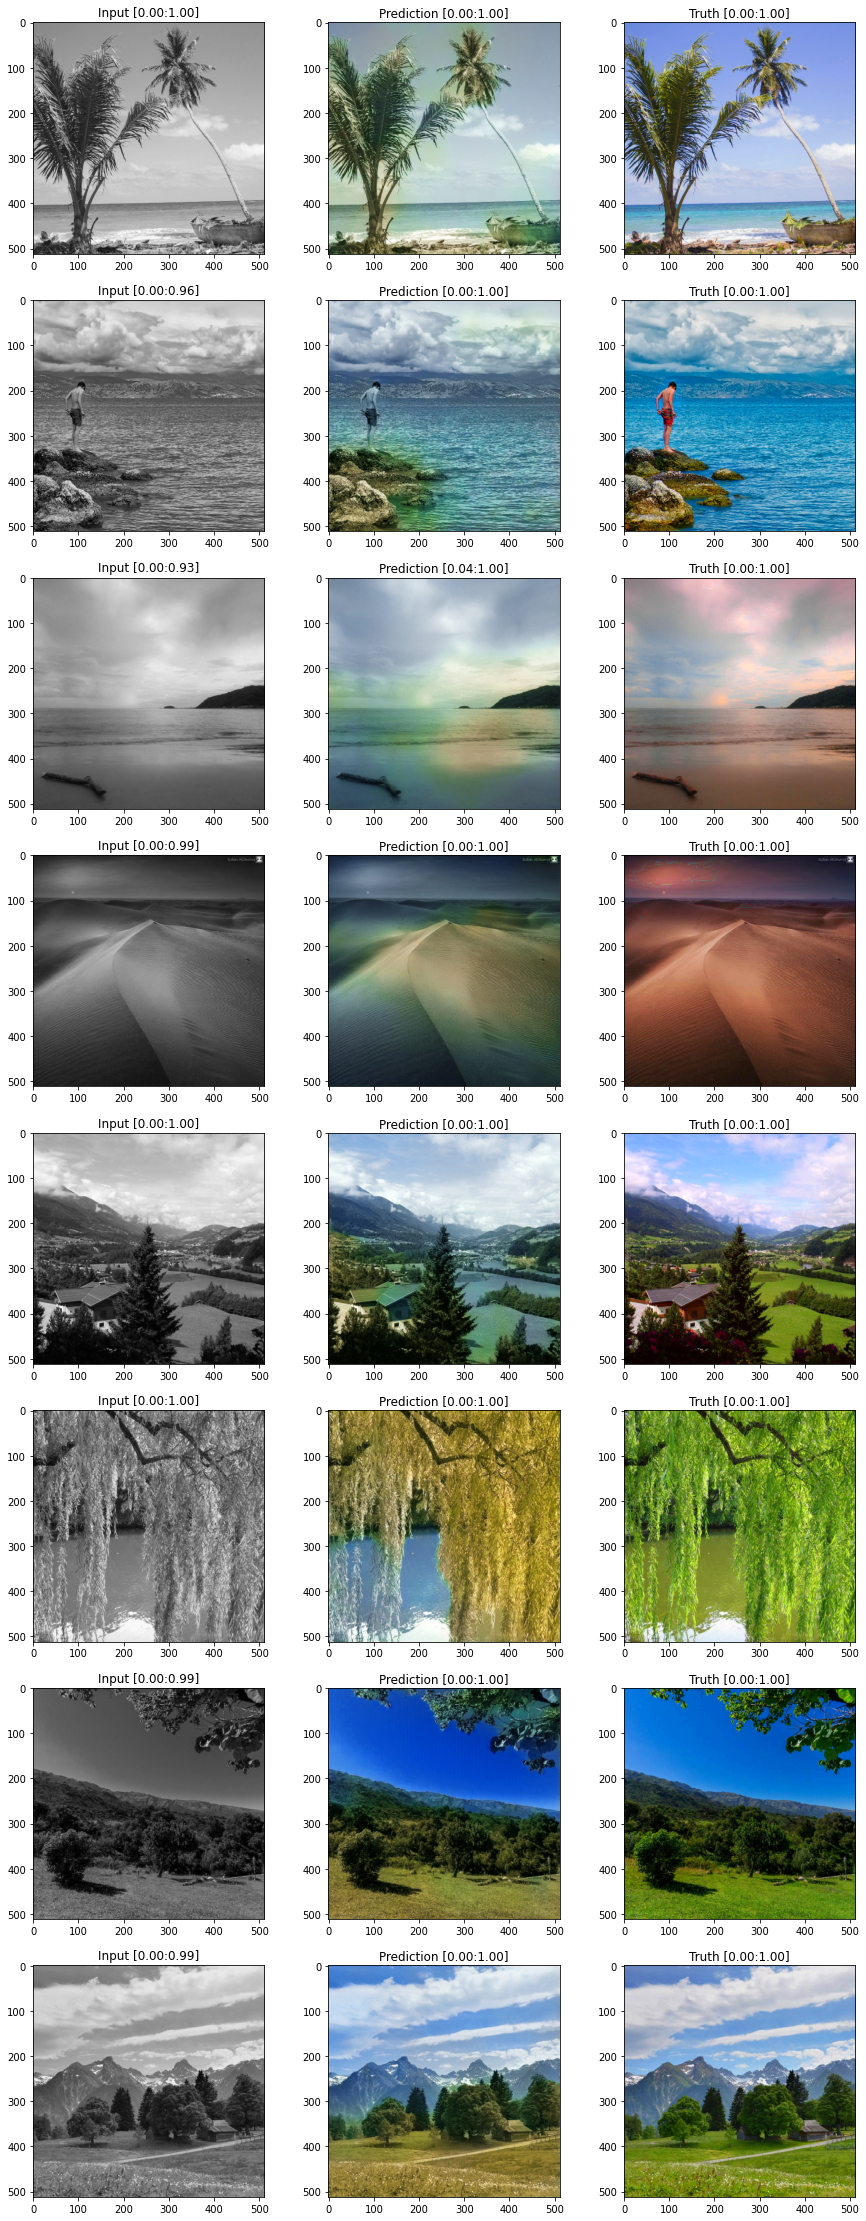

In [21]:
import random
import pathlib
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import load_img, img_to_array, array_to_img
from keras.models import Model


if 'checkpoint_train' in locals() and 'training' not in locals():
    print("Loading weights...")
    model.load_weights(checkpoint_train)

def load_hsv(array):
    return Image.fromarray(np.uint8(array * 255.0), mode='HSV').convert('RGB')

def load_lum(array):
    return Image.fromarray(np.uint8(np.squeeze(array * 255.0, axis=-1)), mode='L').convert('RGB')

n = 8
originals = random.sample(sorted(pathlib.Path('/content/training/').resolve().iterdir()), n)
plt.figure(figsize=(3 * 5, n * 5))
i = 0

for original in originals:
    pair = np.load(original)
    inpt = pair['input']
    truth = pair['truth']
    pred = model.predict(np.array([inpt]))[0]
    pred_ = tf.math.minimum(1.0, tf.nn.relu(pred))

    img_1 = load_hsv(inpt)
    img_2 = load_hsv(pred)
    img_3 = load_hsv(truth)

    plt.subplot(n, 3, i + 1)
    plt.title(f"Input [{np.min(inpt):.2f}:{np.max(inpt):.2f}]")
    plt.imshow(img_1, interpolation=None, cmap='gray')

    plt.subplot(n, 3, i + 2)
    plt.title(f"Prediction [{np.min(pred):.2f}:{np.max(pred):.2f}]")
    plt.imshow(img_2, interpolation=None)

    plt.subplot(n, 3, i + 3)
    plt.title(f"Truth [{np.min(truth):.2f}:{np.max(truth):.2f}]")
    plt.imshow(img_3, interpolation=None)
    
    i += 3

dict_keys(['loss', 'mean_absolute_error', 'SSIM', 'SSIM_L', 'PSNR'])


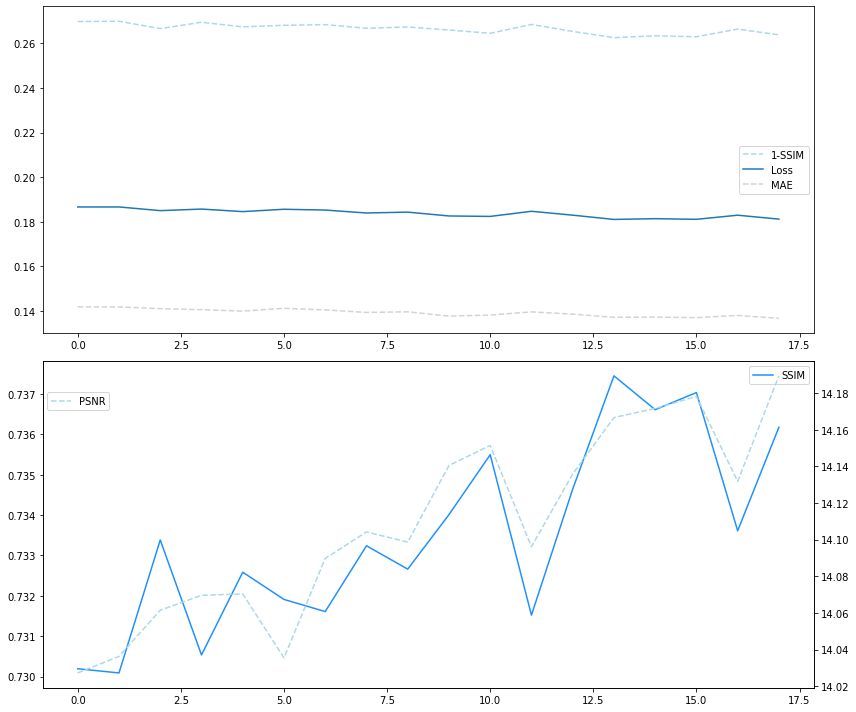

In [10]:
!pip install -qq matplotlib
from matplotlib import pyplot as plt

def plot_performance(history):
    print(history.history.keys())
    loss = history.history['loss']
    dssim = history.history['SSIM_L']
    ssim = history.history['SSIM']
    mae = history.history['mean_absolute_error']
    psnr = history.history['PSNR']

    nb_epochs = len(loss)
    epochs_range = range(nb_epochs)

    fig, (axlosses, axmetrics) = plt.subplots(2, figsize=(12, 10))
    #axlosses.plot(epochs_range, psnr2, label='PSNR-L', color='aquamarine', linestyle='dotted')
    axlosses.plot(epochs_range, dssim, label='1-SSIM', color='lightblue', linestyle='dashed')
    axlosses.plot(epochs_range, loss, label='Loss', color='tab:blue')
    axlosses.plot(epochs_range, mae, label='MAE', color='lightgray', linestyle='dashed')
    axlosses.legend(labels=['1-SSIM', 'Loss', 'MAE'])

    axmetrics.plot(epochs_range, ssim, label='SSIM', color='dodgerblue')
    axmetrics.legend(labels=['SSIM'])
    
    axmetrics2 = axmetrics.twinx()
    axmetrics2.plot(epochs_range, psnr, label='PSNR', color='lightblue', linestyle='dashed')
    axmetrics2.legend(labels=['PSNR'], loc=(0.005, 0.85))
    
    fig.tight_layout()
    fig.show()


plot_performance(training)